<a href="https://colab.research.google.com/github/Elman295/MLP-Mixer-for-MNIST-Classification/blob/main/MLP_Mixer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn

#`Data`

In [ ]:
train_data = datasets.MNIST(
    root = "data",
    train = True,
    download = True,
    transform = transforms.ToTensor()
)

test_data = datasets.MNIST(
    root = "data",
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 50712909.76it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 2391528.35it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 14498085.82it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1680978.45it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
x,y = train_data[0]
print(x.shape)
print(y)

torch.Size([1, 28, 28])
5


In [ ]:
def patchify(image, size = 4):

  c,w,h = image.shape
  num_patch = w // size
  # print(num_patch)
  image = image.view(c,num_patch,size,num_patch,size)
  image = image.permute(0,1,3,2,4)
  image = image.reshape(c,num_patch**2,size,size)
  return image

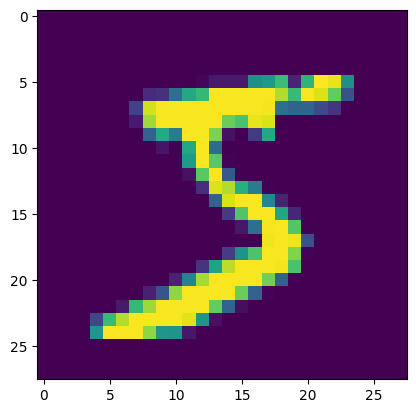

In [ ]:
plt.imshow(x.view(28,28))
plt.show()

In [ ]:
x_p = patchify(x)
print(x_p.shape)

torch.Size([1, 49, 4, 4])


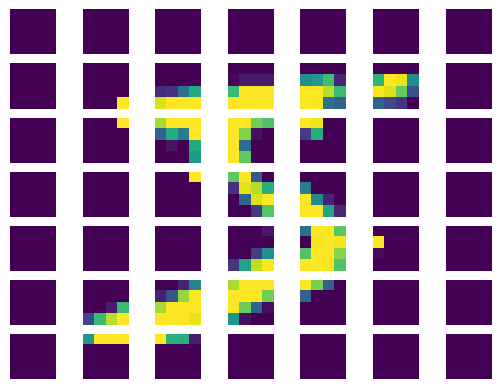

In [ ]:
for i in range(49):
  plt.subplot(7,7,i+1)
  plt.axis("off")
  plt.imshow(x_p[:,i,:,:].reshape(4,4))
plt.show()


In [ ]:
class DS(Dataset):

  def __init__(self,data):
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):

    image,label = self.data[idx]
    patches = patchify(image)
    return patches, label

In [ ]:
train_ds = DS(train_data)
test_ds = DS(test_data)

In [ ]:
train_dl = DataLoader(dataset = train_ds, batch_size = 64, shuffle = True)
test_dl = DataLoader(dataset = test_ds, batch_size = 64, shuffle = False)

In [ ]:
x,y = next(iter(train_dl))
print(x.shape)
print(y.shape)

torch.Size([64, 1, 49, 4, 4])
torch.Size([64])


#`MLP-Mixer`

In [ ]:
class MLP_Mixer_Block(nn.Module):

  def __init__(self):
    super(MLP_Mixer_Block, self).__init__()
    # self.per_path_FC = nn.Linear(16,120)
    self.MLP_2 = nn.Sequential(
        nn.Linear(120,64),
        nn.GELU(),
        nn.Linear(64,120)
    )

    self.MLP_1 = nn.Sequential(
        nn.Linear(49,120),
        nn.GELU(),
        nn.Linear(120,49)
    )

    self.layer_norm_1 = nn.LayerNorm(120)
    self.layer_norm_2 = nn.LayerNorm(120)

  def forward(self, x):

    x = x.view(-1,49,120)
    # x = self.per_path_FC(x)
    x_norm_1 = self.layer_norm_1(x)
    x_T_1 = x_norm_1.permute(0,2,1)
    x_MLP_1 = self.MLP_1(x_T_1)
    x_T_2 = x_MLP_1.permute(0,2,1) + x
    x_norm_2 = self.layer_norm_2(x_T_2)
    x_MLP_2 = self.MLP_2(x_norm_2) + x_T_2

    return x_MLP_2


In [ ]:
x = torch.rand(size = (16,49,120))
model = MLP_Mixer_Block()
y = model(x)
print(y.shape)

torch.Size([16, 49, 120])


In [ ]:
class MLP_Mixer(nn.Module):

  def __init__(self, num_blocks = 4):
    super(MLP_Mixer, self).__init__()
    self.per_path_FC = nn.Linear(16,120)

    self.MLP_Mixer = nn.Sequential(*[MLP_Mixer_Block() for i in range(num_blocks)])
    self.GAVG = nn.AvgPool1d(4)
    self.head = nn.Linear(49*30,10)


  def forward(self, x):

    x = x.view(-1,49,16)
    x = self.per_path_FC(x)
    f = self.MLP_Mixer(x)
    f = self.GAVG(f)
    f = f.view(-1,49*30)
    f = self.head(f)
    return f


In [ ]:
model_main = MLP_Mixer()
x = torch.rand(size = (16,49,4,4))
y = model_main(x)
print(y.shape)

torch.Size([16, 10])


In [ ]:
model_main

MLP_Mixer(
  (per_path_FC): Linear(in_features=16, out_features=120, bias=True)
  (MLP_Mixer): Sequential(
    (0): MLP_Mixer_Block(
      (MLP_2): Sequential(
        (0): Linear(in_features=120, out_features=64, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=64, out_features=120, bias=True)
      )
      (MLP_1): Sequential(
        (0): Linear(in_features=49, out_features=120, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=120, out_features=49, bias=True)
      )
      (layer_norm_1): LayerNorm((120,), eps=1e-05, elementwise_affine=True)
      (layer_norm_2): LayerNorm((120,), eps=1e-05, elementwise_affine=True)
    )
    (1): MLP_Mixer_Block(
      (MLP_2): Sequential(
        (0): Linear(in_features=120, out_features=64, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=64, out_features=120, bias=True)
      )
      (MLP_1): Sequential(
        (0): Linear(in_features=49, out_feature

#`Train LOOPs`

In [ ]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(params = model_main.parameters(), lr = 1e-3)

In [ ]:
def train(data, model, loss_fn, opt):
  model.train()
  size = len(data.dataset)

  for b, (x,y) in enumerate(data):
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    opt.zero_grad()
    loss.backward()
    opt.step()


    if b % 100 == 0:
      print(f"loss:{loss.item()} size:[{b*len(x)} | {size}]")

In [ ]:
def test(data, model, loss_fn):

  model.eval()
  size = len(data.dataset)
  num_batch = len(data)

  test_loss, test_acc = 0,0

  with torch.no_grad():
    for x,y in data:
      y_pred = model(x)
      test_loss += loss_fn(y_pred, y).item()
      test_acc += (y_pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batch
    test_acc /= size
    print(f"test loss:{test_loss} acc:{test_acc * 100}")


In [98]:
for e in range(20):
  print(f"epoch:{e+1}=-=-=-")
  train(train_dl, model_main,loss_fn, opt)
  test(test_dl, model_main, loss_fn)

epoch:1=-=-=-
loss:2.3597755432128906 size:[0 | 60000]
loss:0.4137707054615021 size:[6400 | 60000]
loss:0.2078135758638382 size:[12800 | 60000]
loss:0.2902889847755432 size:[19200 | 60000]
loss:0.18358106911182404 size:[25600 | 60000]
loss:0.3197757601737976 size:[32000 | 60000]
loss:0.19677212834358215 size:[38400 | 60000]
loss:0.045100729912519455 size:[44800 | 60000]
loss:0.1297917515039444 size:[51200 | 60000]
loss:0.06989997625350952 size:[57600 | 60000]
test loss:0.08763586458431966 acc:97.24000000000001
epoch:2=-=-=-
loss:0.1000906229019165 size:[0 | 60000]
loss:0.1139708012342453 size:[6400 | 60000]
loss:0.0937158539891243 size:[12800 | 60000]
loss:0.1263829618692398 size:[19200 | 60000]
loss:0.10794897377490997 size:[25600 | 60000]
loss:0.028042208403348923 size:[32000 | 60000]
loss:0.06250535696744919 size:[38400 | 60000]
loss:0.11699160933494568 size:[44800 | 60000]
loss:0.1252858191728592 size:[51200 | 60000]
loss:0.11127277463674545 size:[57600 | 60000]
test loss:0.0707450

In [104]:
test_dl = DataLoader(dataset = test_ds, batch_size = 2000)

In [105]:
x_test,y_test = next(iter(test_dl))
y_pred = model_main(x_test)

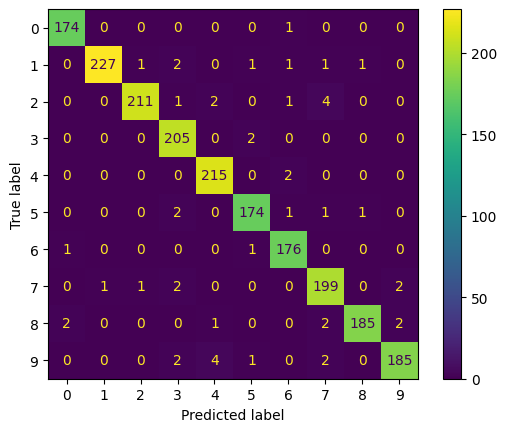

In [106]:
mt = confusion_matrix(y_test.numpy(), y_pred.argmax(1).numpy())
ConfusionMatrixDisplay(mt).plot()